In [27]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import obspy
# from tqdm import tqdm
from glob import glob
# import time
import random
import sys
from datetime import datetime
from tqdm import tqdm

from scipy import stats,signal
from scipy.signal import spectrogram


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
# from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset


import numpy as np
import scipy.signal as signal



# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


# Get the current working directory
notebook_dir = os.getcwd()

# Add the ../src directory to the Python path
src_path = os.path.abspath(os.path.join(notebook_dir, 'scripts'))
sys.path.insert(0, src_path)

from neural_network_architectures import QuakeXNet_1d
from neural_network_architectures import QuakeXNet_2d

from neural_network_architectures import SeismicCNN_1d
from neural_network_architectures import SeismicCNN_2d

from neural_network_architectures import BasicResNet_1d
from neural_network_architectures import BasicResNet_2d


from helper_functions import extract_waveforms
from helper_functions import extract_spectrograms
from helper_functions import return_train_test_val_loaders
from helper_functions import train_model
from helper_functions import plot_confusion_matrix_and_cr


import torch
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz




a = []
fs = 50
def extract_spectrograms(waveforms = a, fs = fs, nperseg=256, overlap=0.5):
    noverlap = int(nperseg * overlap)  # Calculate overlap

    # Example of how to get the shape of one spectrogram
    f, t, Sxx = signal.spectrogram(waveforms[0, 0], nperseg=nperseg, noverlap=noverlap, fs=fs)

    # Initialize an array of zeros with the shape: (number of waveforms, channels, frequencies, time_segments)
    spectrograms = np.zeros((waveforms.shape[0], waveforms.shape[1], len(f), len(t)))

    for i in tqdm(range(waveforms.shape[0])):  # For each waveform
        for j in range(waveforms.shape[1]):  # For each channel
            _, _, Sxx = signal.spectrogram(waveforms[i, j], nperseg=nperseg, noverlap=noverlap, fs=fs)
            spectrograms[i, j] = Sxx  # Fill the pre-initialized array

    print(spectrograms.shape)
    return f,t, spectrograms


cuda


In [11]:
## setting up some important parameters (not to be changed)
num_channels = 3
dropout = 0.9
# Check if a GPU is available
device = 'cpu'   #torch.device("cuda" if torch.cuda.is_available() else "cpu")



## initiating the model architectures - 
#model_seismiccnn_1d = SeismicCNN_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
model_seismiccnn_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
model_quakexnet_1d = QuakeXNet_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
model_quakexnet_2d = QuakeXNet_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
model_basicresnet_2d = BasicResNet_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available




# Load the saved model state dict (weights)
saved_model_seismiccnn_2d = torch.load('trained_models/best_model_SeismicCNN_2d.pth', map_location=torch.device('cpu'))  # No'weights_only' argument

# Load the saved model state dict (weights)
saved_model_quakexnet_2d = torch.load('trained_models/best_model_QuakeXNet_2d.pth', map_location=torch.device('cpu'))  # No 'weights_only' argument

# Load the saved model state dict (weights)
saved_model_quakexnet_1d = torch.load('trained_models/best_model_QuakeXNet_1d.pth', map_location=torch.device('cpu'))  # No 'weights_only' argument



# Load the state dict into the model
model_seismiccnn_2d.load_state_dict(saved_model_seismiccnn_2d)
model_quakexnet_2d.load_state_dict(saved_model_quakexnet_2d)

model_quakexnet_1d.load_state_dict(saved_model_quakexnet_1d)



# Move the model to the correct device (GPU or CPU)
model_seismiccnn_2d.to(device)
model_quakexnet_2d.to(device)

model_quakexnet_1d.to(device)


# Put the model in evaluation mode (important for models with dropout/batch norm layers)
model_seismiccnn_2d.eval()
model_quakexnet_2d.eval()
model_quakexnet_1d.eval()

/tmp/ipykernel_1238431/1893506516.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model_seismiccnn_2d = torch.load('trained_models/best_model_SeismicCNN_2d.pth', 

QuakeXNet_1d(
  (conv1): Conv1d(3, 8, kernel_size=(9,), stride=(1,), padding=(4,))
  (conv2): Conv1d(8, 8, kernel_size=(9,), stride=(2,), padding=(4,))
  (conv3): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv4): Conv1d(16, 16, kernel_size=(7,), stride=(2,), padding=(3,))
  (conv5): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv6): Conv1d(32, 32, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv7): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affi

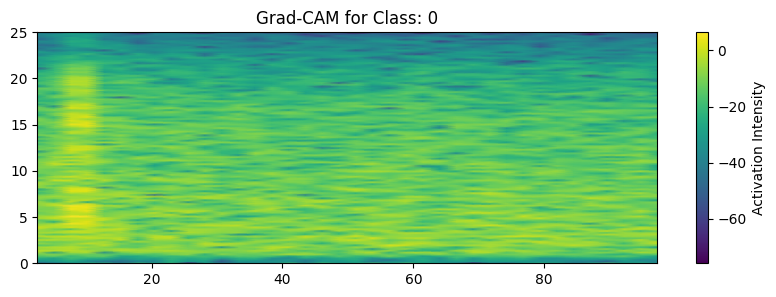

In [47]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Forward hook to capture activations
        self.target_layer.register_forward_hook(self.save_activations)
        
        # Backward hook to capture gradients
        self.target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output  # Shape: (batch, channels, H, W)

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]  # Shape: (batch, channels, H, W)

    def compute_heatmap(self, class_idx):
        # Average the gradients across the channels
        pooled_grads = torch.mean(self.gradients, dim=[0, 2, 3], keepdim=True)  # (1, channels, 1, 1)
        
        # Weight the activations using the pooled gradients
        weighted_activations = self.activations * pooled_grads  # (batch, channels, H, W)

        # Sum across channels
        heatmap = torch.sum(weighted_activations, dim=1).squeeze()  # Shape: (H, W)
        
        # Apply ReLU
        heatmap = F.relu(heatmap)

        # Normalize between 0 and 1
        heatmap -= heatmap.min()
        heatmap /= (heatmap.max() + 1e-10)  # Avoid division by zero

        # Convert to NumPy for visualization
        return heatmap.cpu().detach().numpy()

# Load model
model = model_quakexnet_2d

# Select last convolutional layer
target_layer = model.conv7
grad_cam = GradCAM(model, target_layer)

# Dummy input (replace with actual spectrogram tensor)
input_tensor =  torch.Tensor(test_waveforms_2d[9].reshape(1,3, 129,38))               #torch.randn(1, 3, 129, 38, requires_grad=True)  # Shape: [batch, channels, height, width]

# Forward pass
output = model(input_tensor)

# Choose the predicted class
predicted_class = output.argmax(dim=1).item()

# Backward pass
model.zero_grad()
output[0, predicted_class].backward()

# Compute heatmap
heatmap = grad_cam.compute_heatmap(predicted_class)

# Resize heatmap to match input spectrogram size
import cv2
heatmap_resized = cv2.resize(heatmap, (38, 129))  # Resize to match (width, height)

# Plot spectrogram and Grad-CAM overlay
plt.figure(figsize=(10, 3))
#plt.imshow(input_tensor[0, 0].cpu().detach().numpy(), cmap='gray', alpha=0.7)  # Original spectrogram
plt.pcolormesh(t, f, 10 * np.log10(input_tensor[0, 0].cpu().detach().numpy()), shading='gouraud')
#plt.pcolormesh(t,f,heatmap_resized, cmap='Blues', alpha=0.9)  # Heatmap overlay
plt.colorbar(label="Activation Intensity")
plt.title(f"Grad-CAM for Class: {predicted_class}")
plt.show()


In [28]:
test_waveforms_1d = np.load('../data/common_test_data_for_deep_learning.npy')
test_labels = np.load('../data/common_test_data_labels_for_deep_learning.npy')

f,t, test_waveforms_2d = extract_spectrograms(test_waveforms_1d)

100%|██████████| 8000/8000 [00:07<00:00, 1033.43it/s]

(8000, 3, 129, 38)


In [51]:
label = 0
index = 0

In [52]:
np.where(test_labels == label)[0][index]

7

In [57]:
def plot_attributions(label = 0, index = 1, target_class = 0):

    event_labels = {0: 'Earthquake', 1: 'Explosion', 2: 'Noise', 3: 'Surface Event'}
    idx = np.where(test_labels == label)[0][index]
    input_tensor = torch.tensor(test_waveforms_2d[idx], dtype=torch.float32).unsqueeze(dim=0)

    # Create the IntegratedGradients object
    ig = IntegratedGradients(model)

    # Compute the attributions
    attributions, delta = ig.attribute(input_tensor, target=target_class, return_convergence_delta=True)

    # Time vector for the 1D waveform
    time = np.linspace(0, 100, 5000)

    # Create the figure and gridspec
    fig, axes = plt.subplots(
        3, 1, 
        figsize=(6, 6), 
        gridspec_kw={'height_ratios': [2, 2, 2]}, 
        sharex = True
    )

    # Plot 1: Time-domain waveform
    axes[0].plot(time, test_waveforms_1d[idx, 0], color='blue')
    axes[0].set_title(f"{event_labels[label]} Waveform", fontsize=14)
    #axes[0].set_xlabel("Time [sec]", fontsize=12)
    axes[0].set_ylabel("Amplitude", fontsize=12)
    axes[0].set_xlim(left=time[0], right=time[-1])

    # Plot 2: Spectrogram of the input
    spectrogram = axes[1].pcolormesh(t, f, 10 * np.log10(input_tensor[0, 0].cpu().detach().numpy()), shading='gouraud')
    #axes[1].set_title("Input Spectrogram", fontsize=14)
    #axes[1].set_xlabel("Time [sec]", fontsize=12)
    axes[1].set_ylabel("Frequency [Hz]", fontsize=12)

    # Plot 3: Attributions over the spectrogram
    attribution_plot = axes[2].pcolormesh(t, f, attributions[0, 0].cpu().detach().numpy(), shading='gouraud', cmap="coolwarm")
    #axes[2].set_title("Attributions Overlay on Spectrogram", fontsize=14)
    axes[2].set_xlabel("Time [sec]", fontsize=12)
    axes[2].set_ylabel("Frequency [Hz]", fontsize=12)

    plt.xlim(5,50)

    # Add colorbars outside the figure
    cbar_ax1 = fig.add_axes([0.9, 0.4, 0.02, 0.20])  # [left, bottom, width, height]
    fig.colorbar(spectrogram, cax=cbar_ax1, label='Intensity [dB]')

    cbar_ax2 = fig.add_axes([0.9, 0.1, 0.02, 0.20])  # [left, bottom, width, height]
    fig.colorbar(attribution_plot, cax=cbar_ax2, label='Attribution Intensity')



    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbars
    plt.show()


In [79]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from captum.attr import IntegratedGradients

def plot_attributions(label=0, index=1, target_class=0):
    event_labels = {0: 'Earthquake', 1: 'Explosion', 2: 'Noise', 3: 'Surface Event'}
    
    idx = np.where(test_labels == label)[0][index]
    input_tensor = torch.tensor(test_waveforms_2d[idx], dtype=torch.float32).unsqueeze(dim=0)

    # Create the IntegratedGradients object
    ig = IntegratedGradients(model)

    # Compute the attributions
    attributions, delta = ig.attribute(input_tensor, target=target_class, return_convergence_delta=True)

    # Time vector for the 1D waveform
    time = np.linspace(0, 100, 5000)

    # Create the figure and gridspec
    fig, axes = plt.subplots(
        3, 1, 
        figsize=(8, 8), 
        gridspec_kw={'height_ratios': [2, 2, 2]}, 
        sharex=True
    )

    # Aesthetic customizations
    plt.rcParams.update({'font.size': 12, 'axes.edgecolor': 'black', 'axes.linewidth': 1.2})

    # Plot 1: Time-domain waveform
    axes[0].plot(time, test_waveforms_1d[idx, 0], color='navy', linewidth=1.5)
    axes[0].set_title(f"{event_labels[label]}", fontsize=14, fontweight='bold')
    axes[0].set_ylabel("Amplitude", fontsize=12)
    axes[0].grid(True, linestyle='--', alpha=0.6)
    axes[0].set_xlim(left=time[0], right=time[-1])

    # Plot 2: Spectrogram of the input
    spectrogram = axes[1].pcolormesh(
        t, f, 10 * np.log10(input_tensor[0, 0].cpu().detach().numpy()), 
        shading='gouraud', cmap='viridis'
    )
    axes[1].set_ylabel("Frequency [Hz]", fontsize=12)
    axes[1].grid(True, linestyle='--', alpha=0.6)

    # Plot 3: Attributions over the spectrogram
    attribution_plot = axes[2].pcolormesh(
        t, f, attributions[0, 0].cpu().detach().numpy(), 
        shading='gouraud', cmap=plt.get_cmap("coolwarm"),
        vmin=-0.05, vmax=0.05
    )
    axes[2].set_xlabel("Time [sec]", fontsize=12)
    axes[2].set_ylabel("Frequency [Hz]", fontsize=12)
    axes[2].grid(True, linestyle='--', alpha=0.6)

    plt.xlim(5, 50)

    # Add colorbars with refined placement
    cbar_ax1 = fig.add_axes([0.92, 0.4, 0.02, 0.20])
    fig.colorbar(spectrogram, cax=cbar_ax1, label='Intensity [dB]')

    cbar_ax2 = fig.add_axes([0.92, 0.1, 0.02, 0.20])
    fig.colorbar(attribution_plot, cax=cbar_ax2, label='Attribution Intensity')

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()


/tmp/ipykernel_1238431/1231162512.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


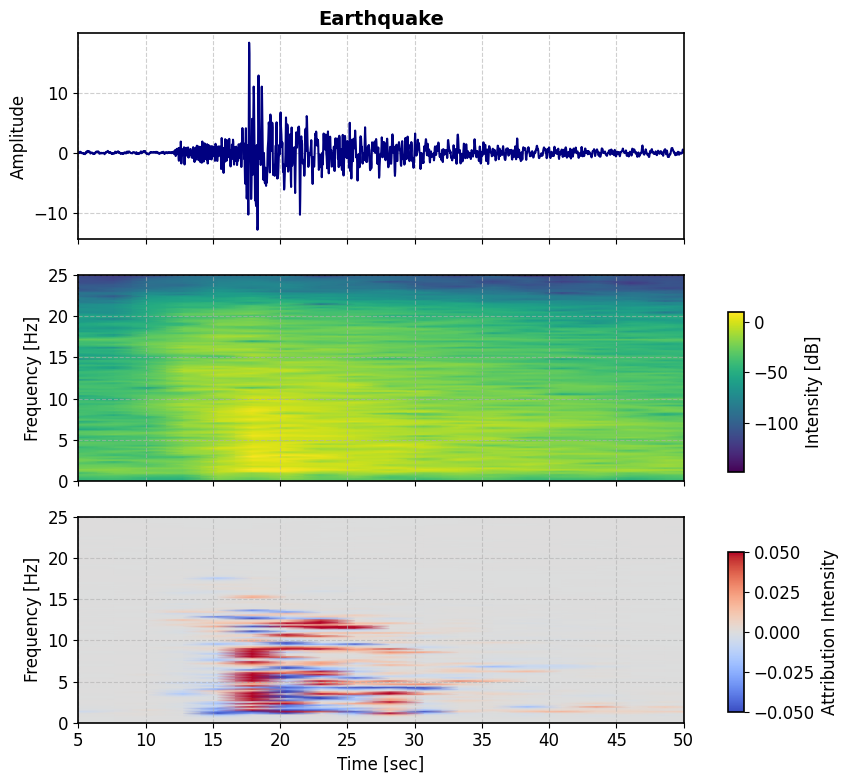

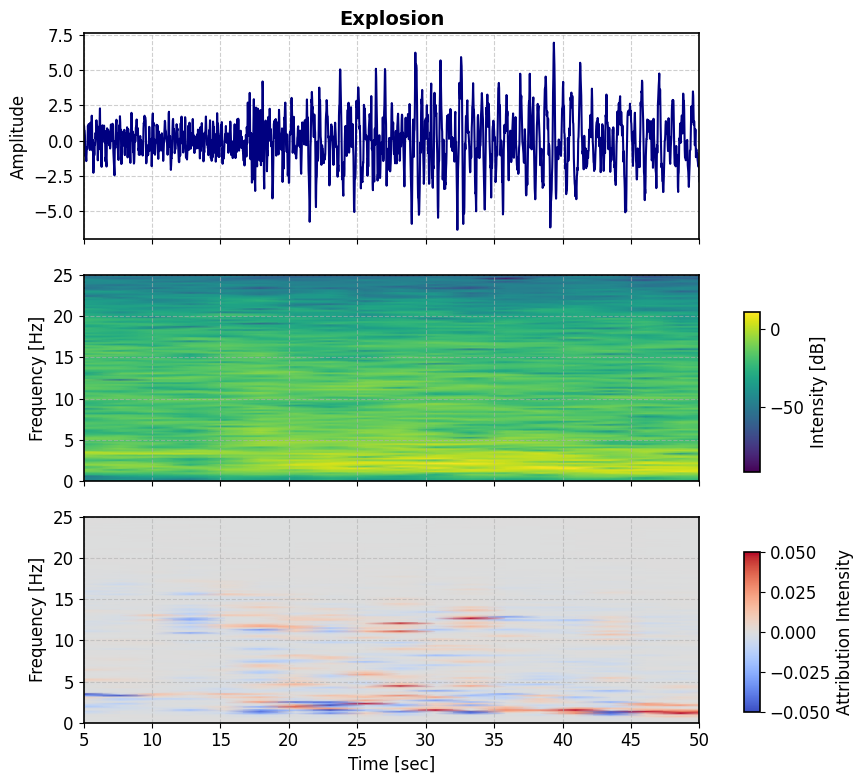

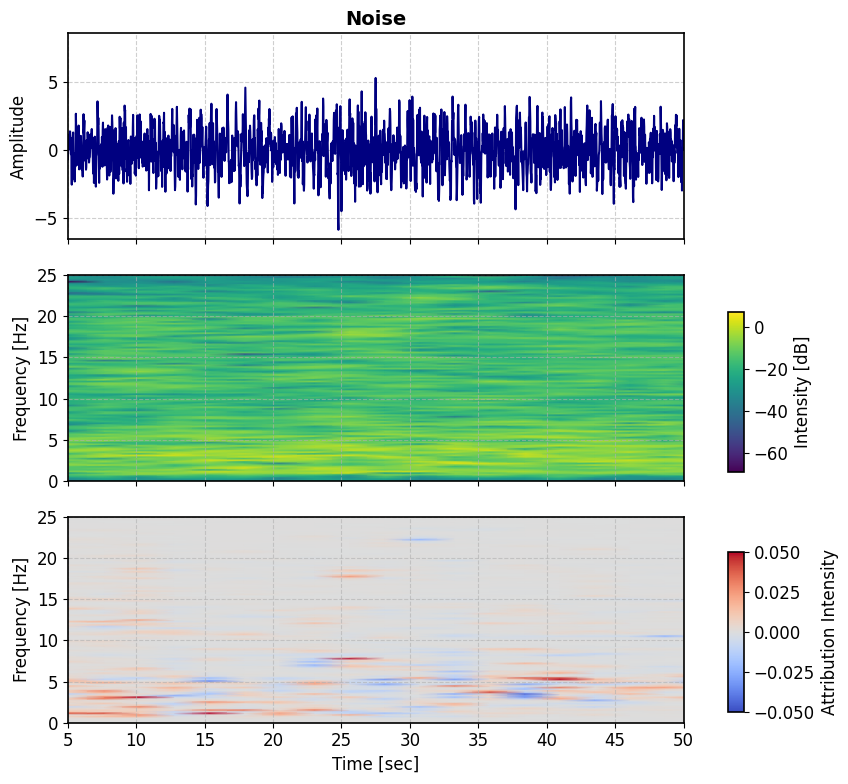

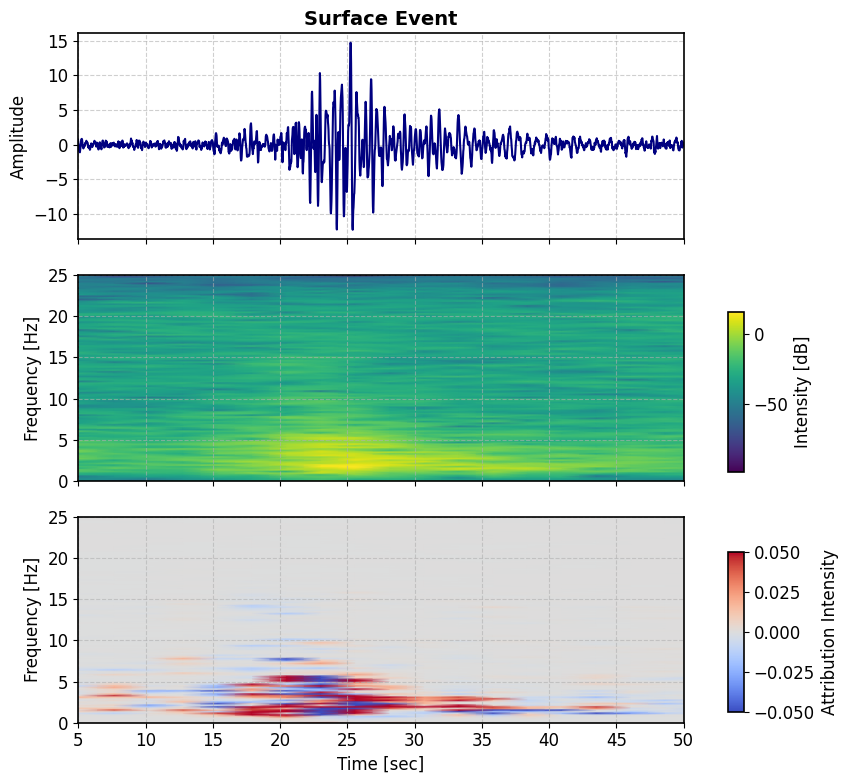

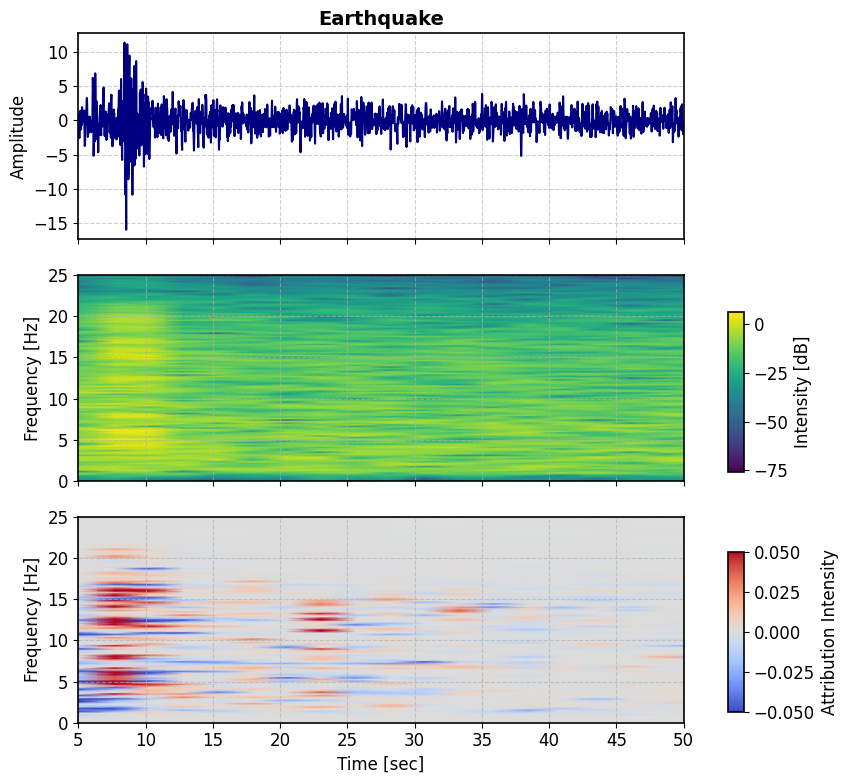

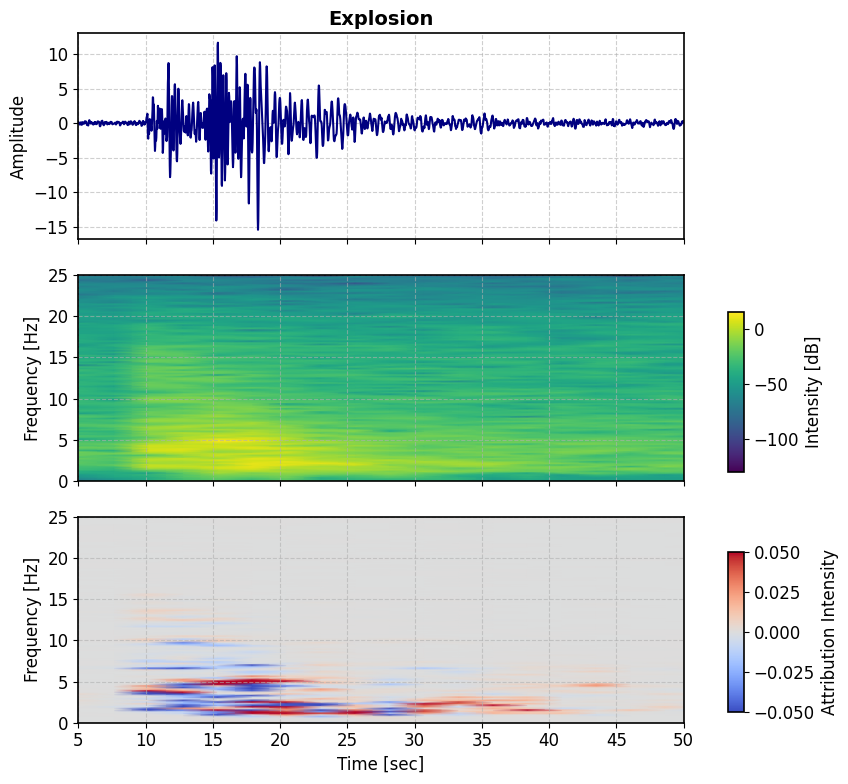

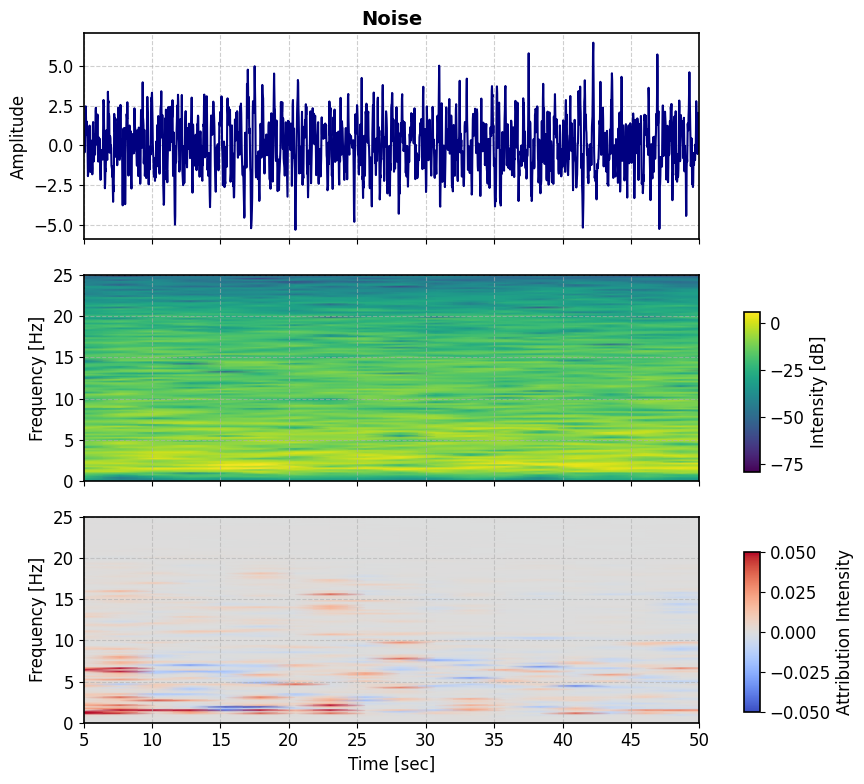

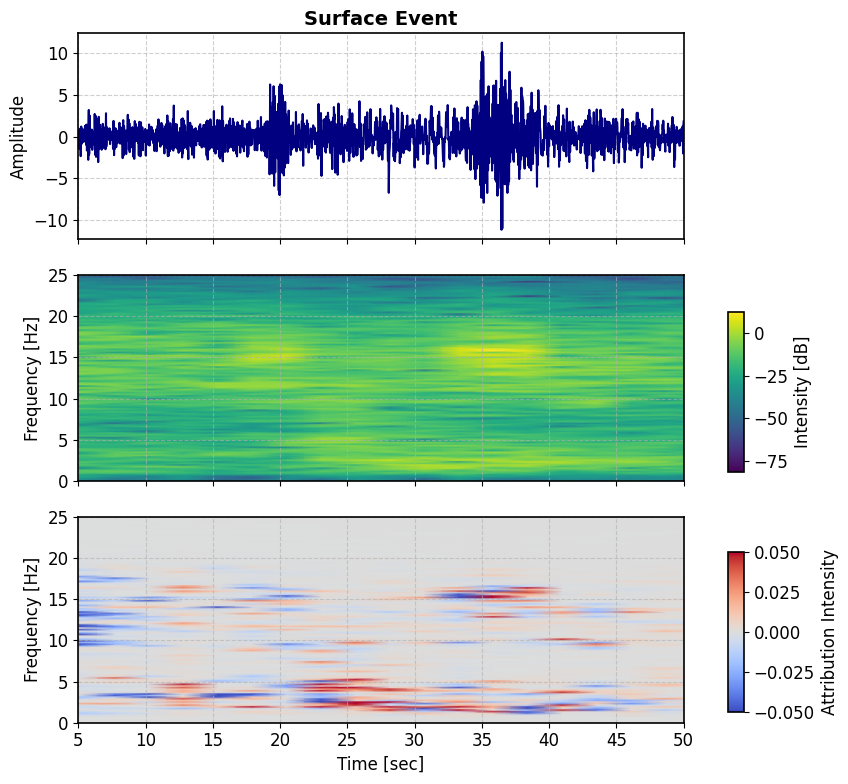

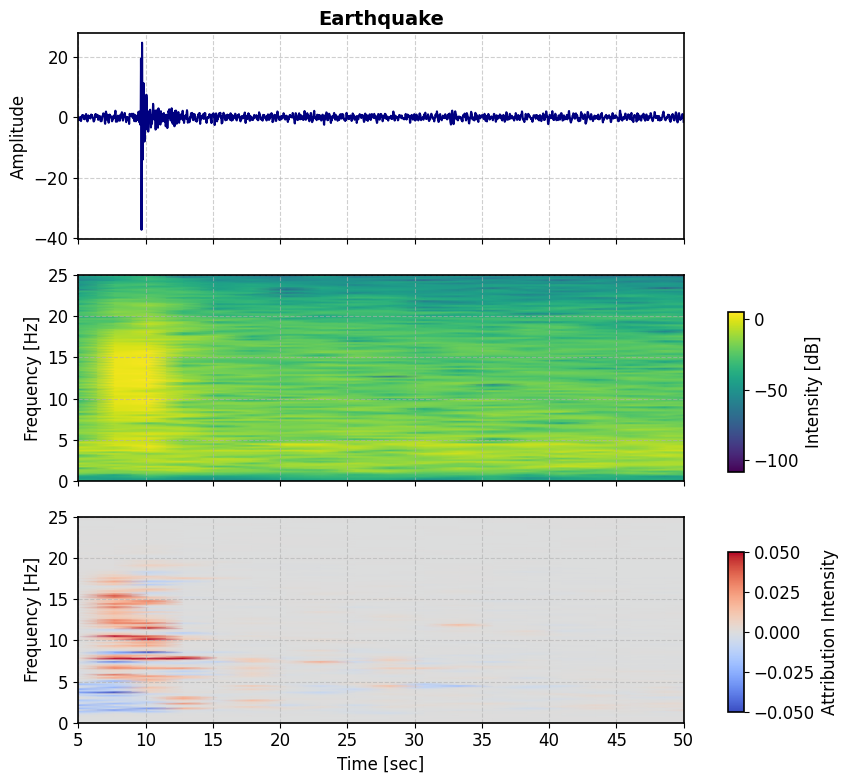

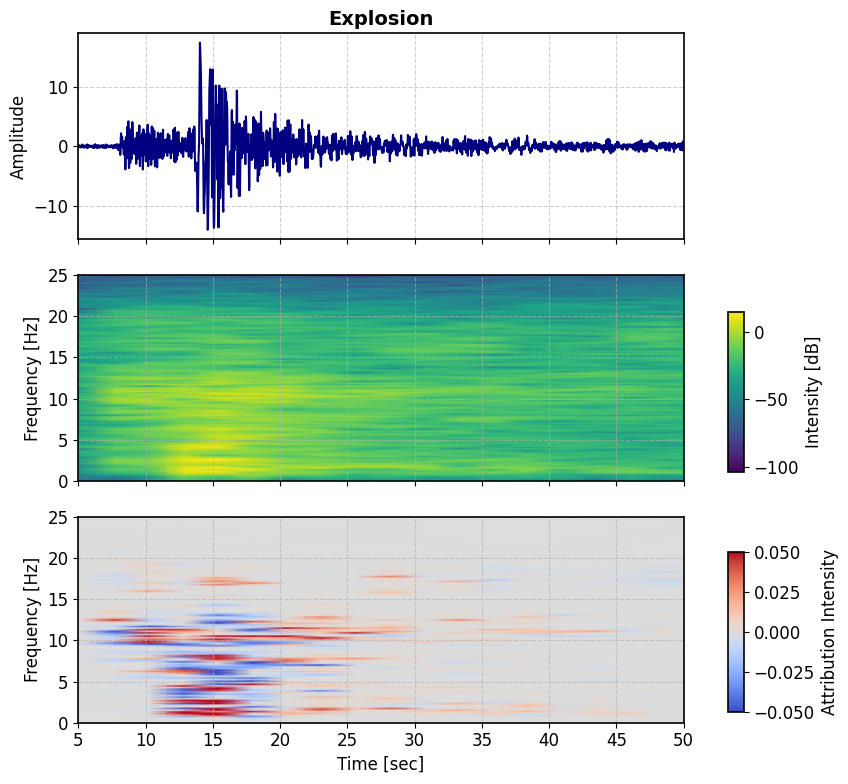

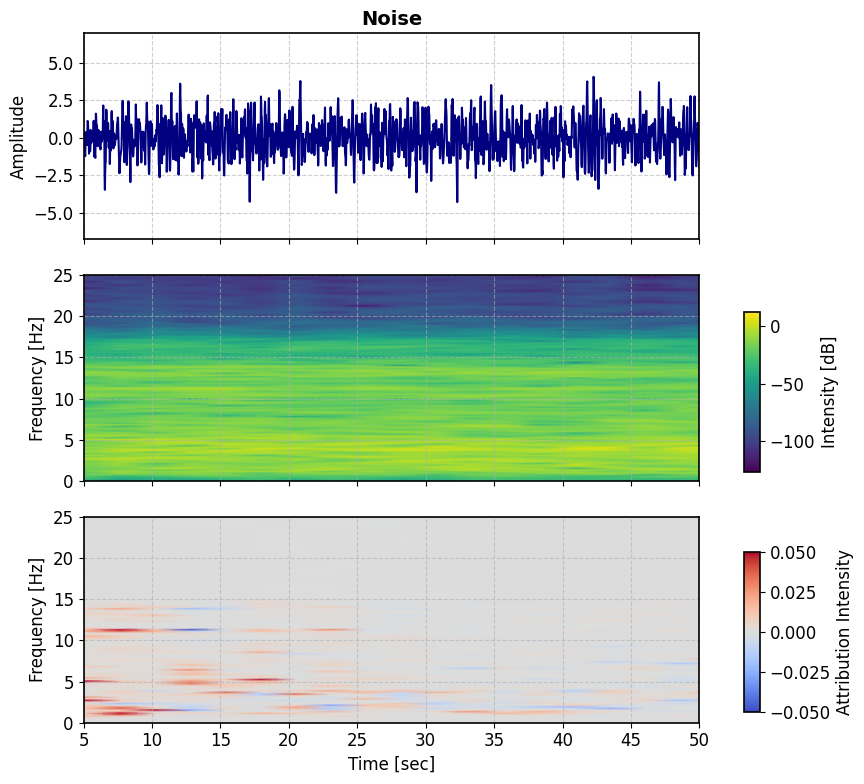

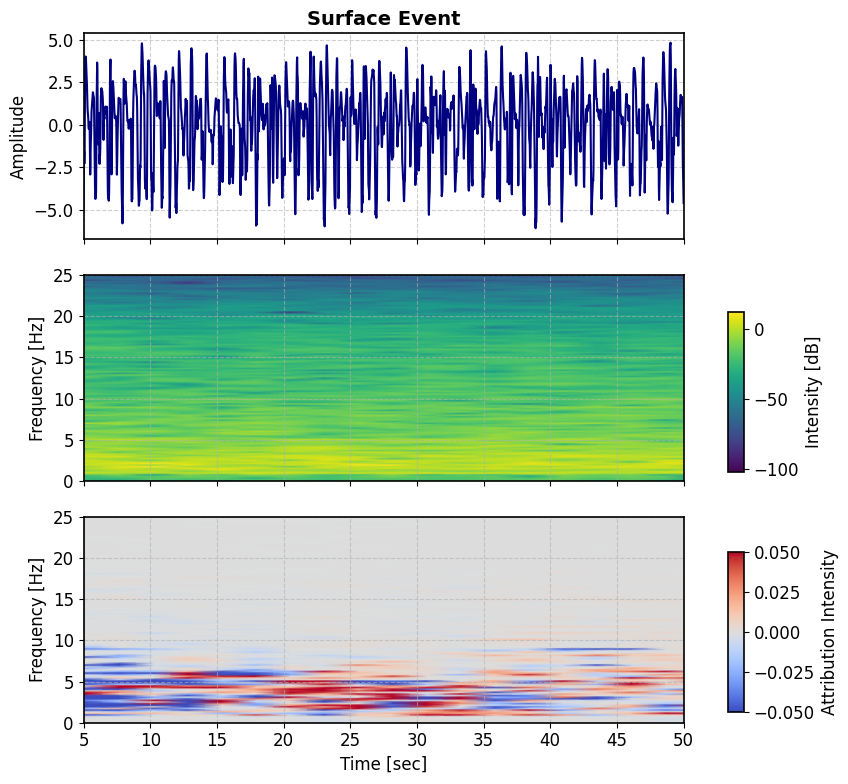

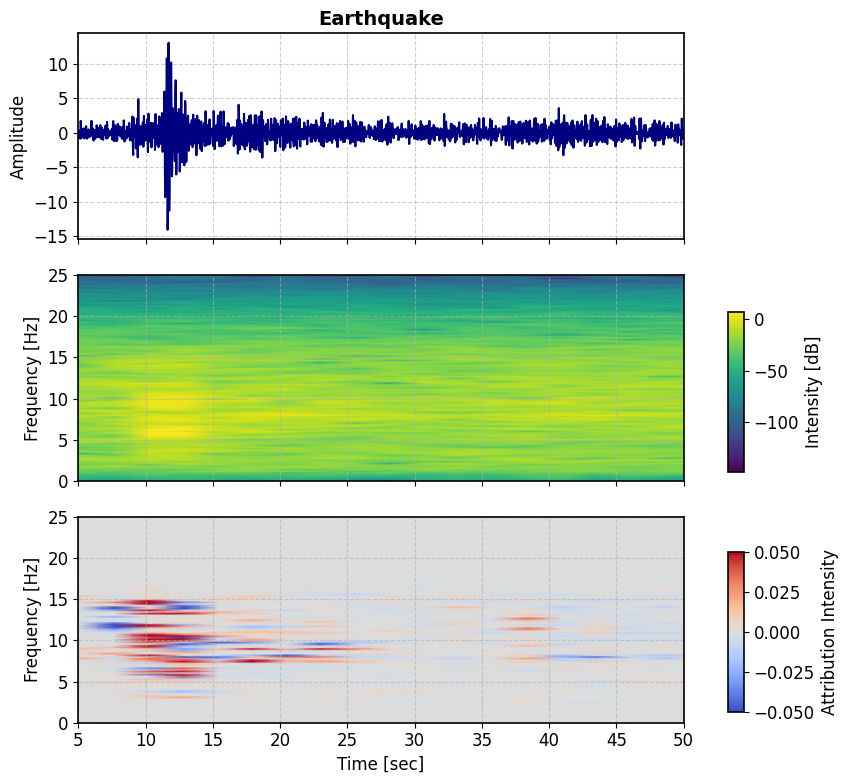

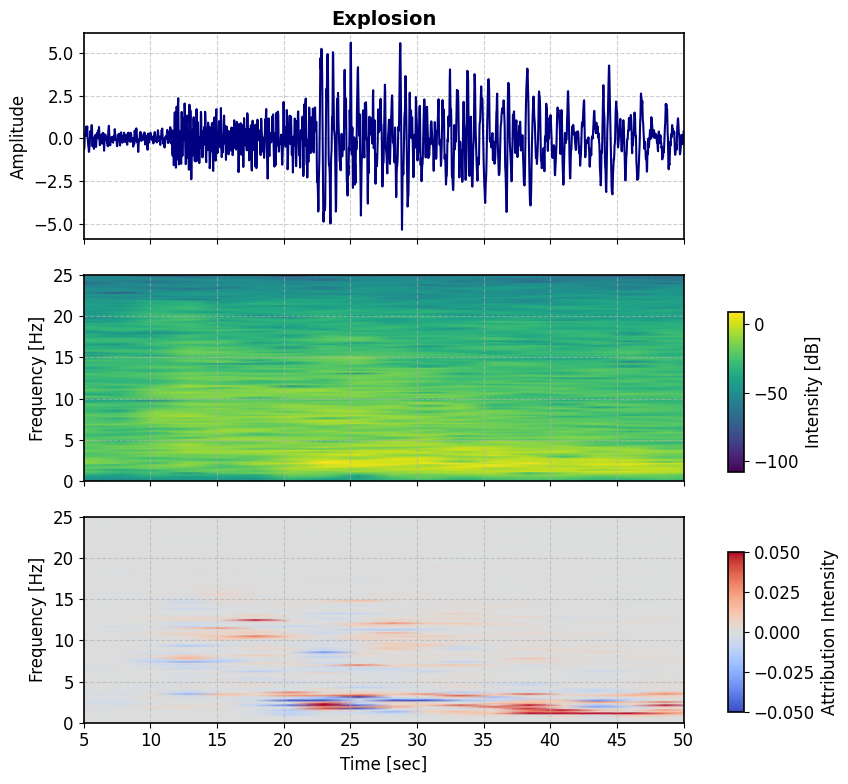

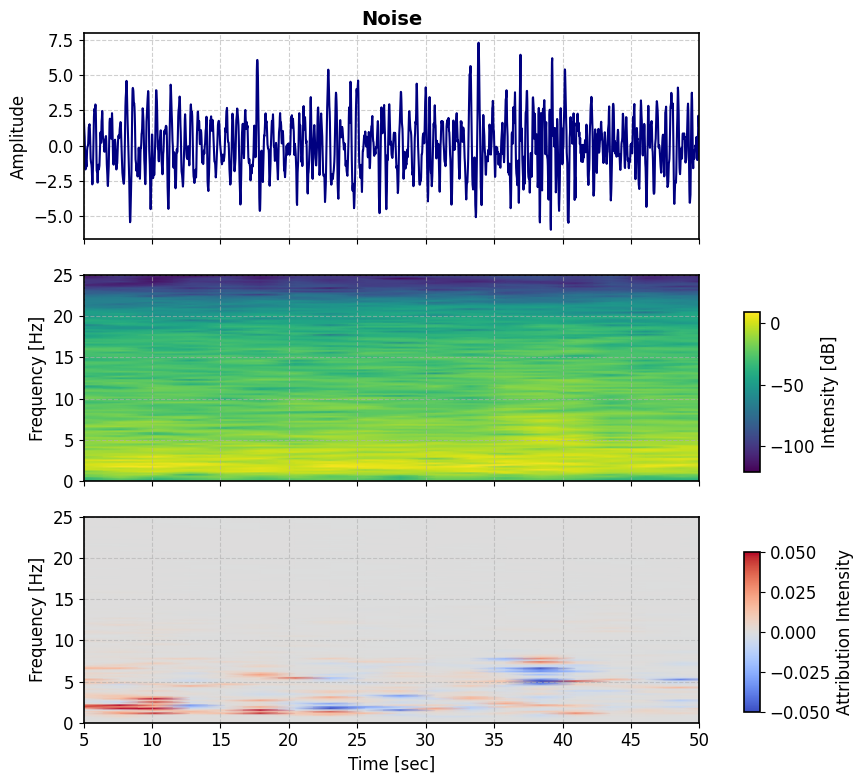

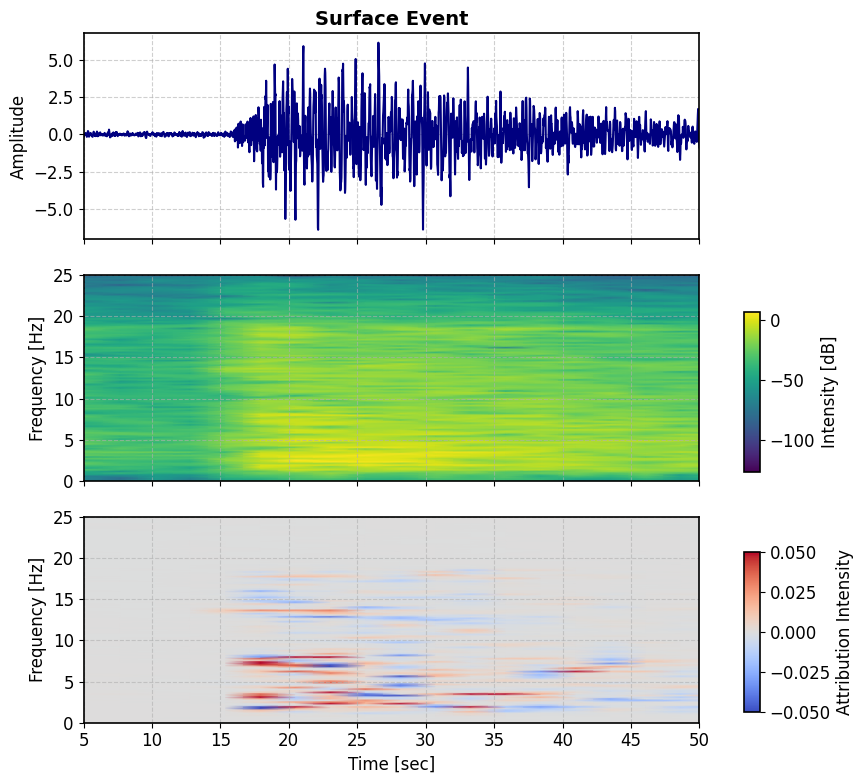

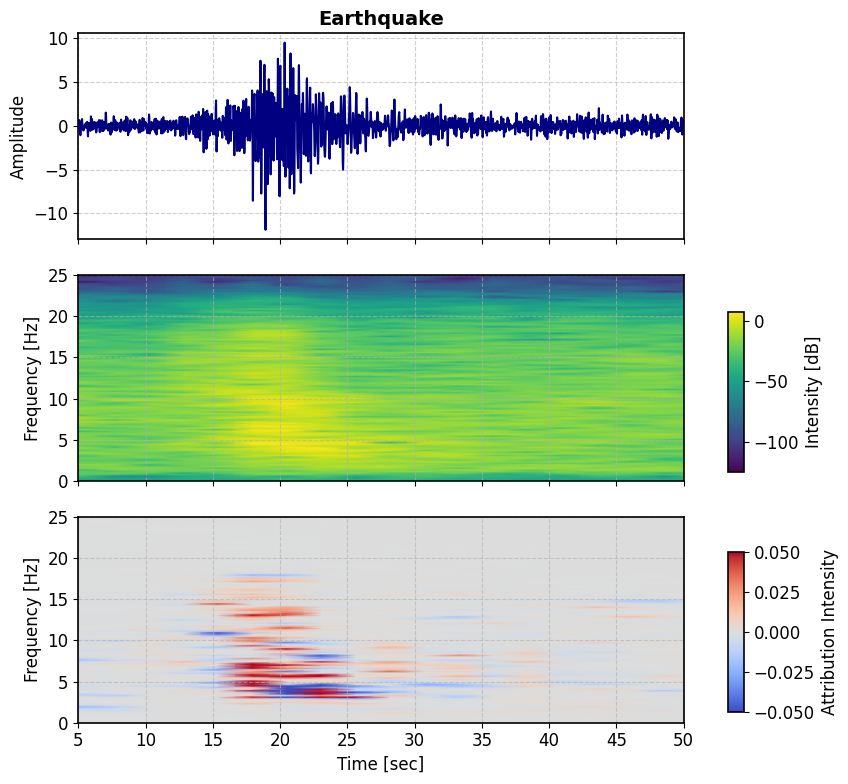

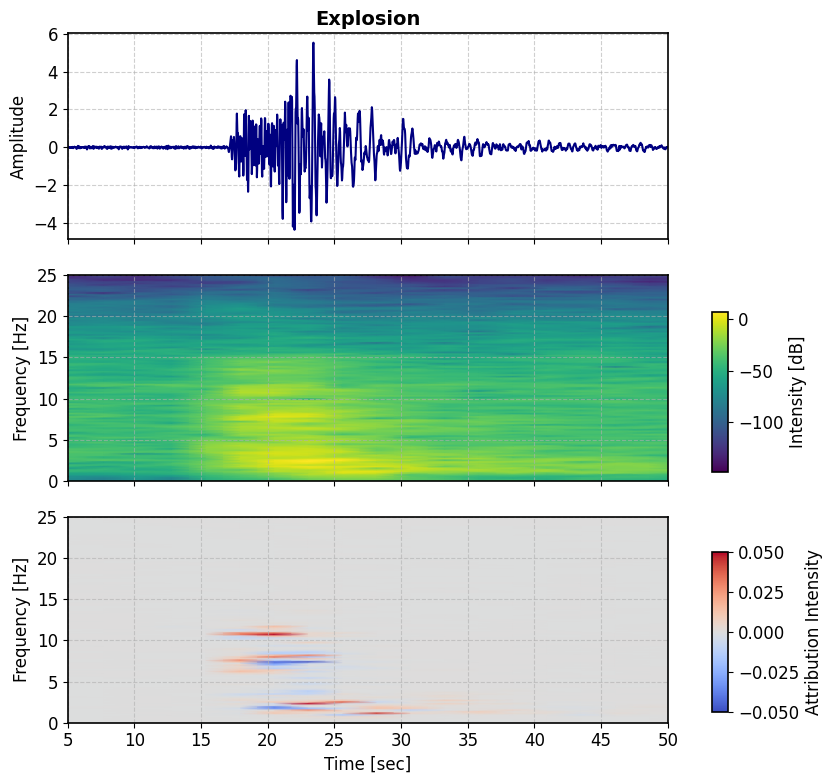

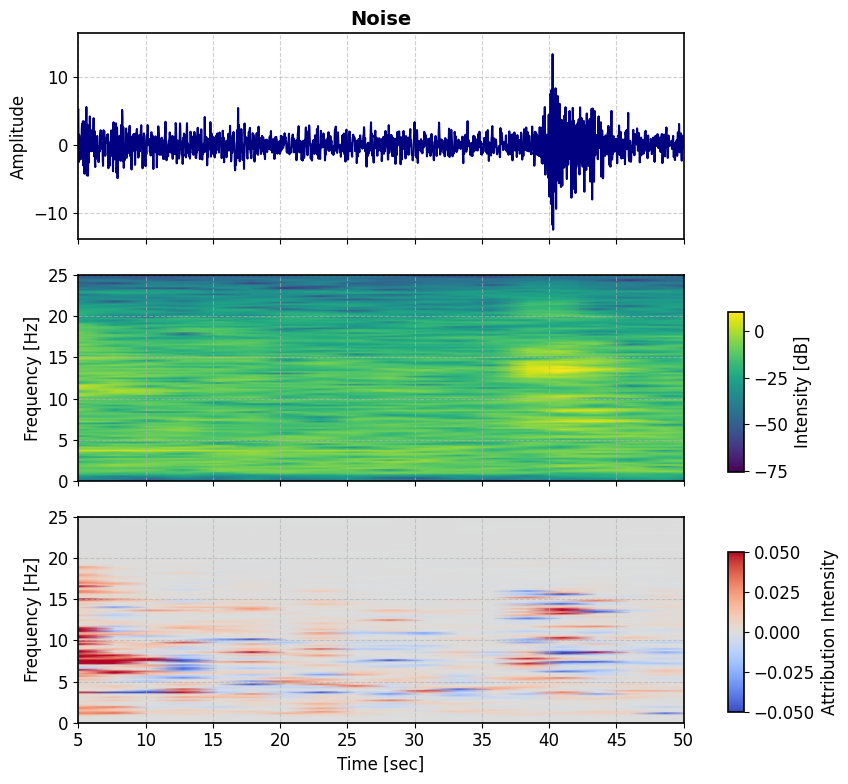

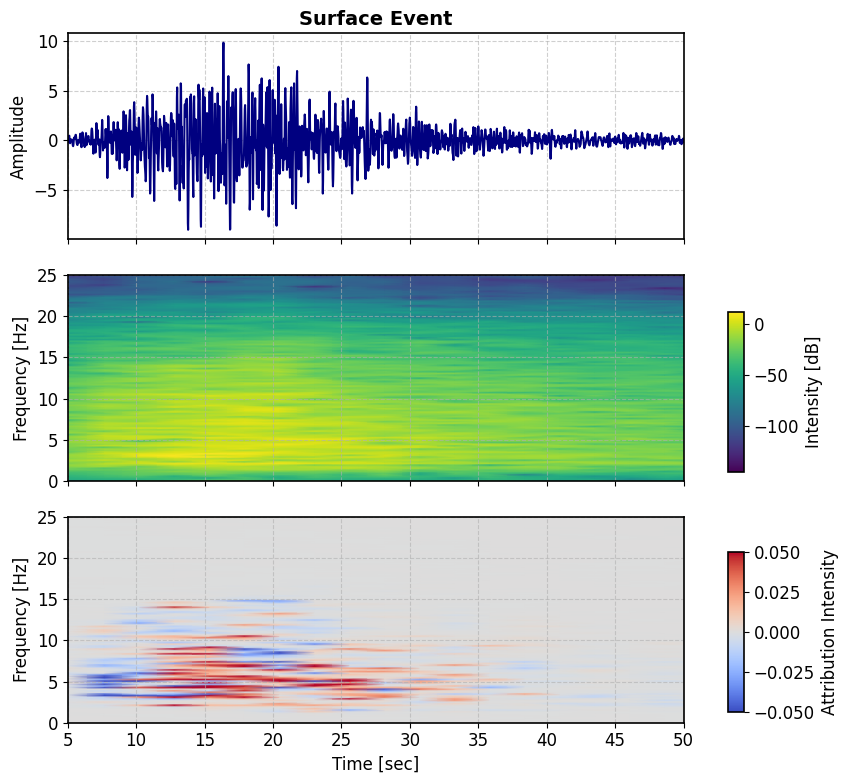

In [80]:
for i in range(5):
    plot_attributions(label = 0, index = i, target_class = 0)
    plot_attributions(label = 1, index = i, target_class = 1)
    plot_attributions(label = 2, index = i, target_class = 2)
    plot_attributions(label = 3, index = i, target_class = 3)